# Word Embeddings and Word2Vec

Word2Vec is an extension of the bigram model using neural networks.

## CBOW

CBOW - Continuous bag of words: Tries to predict a word given their surrounding words in a *Context*.

1. Train a matrix $W_1$ with the embeddings of all words
2. Given a set $C$ of all context words, take the average of all their embeddings: $h = \sum_{c \in C} W_1 c$
3. Get probability of target word $y$: $p(y | C) = softmax(W_2^T h)$

## Skip-Gram

This is the opposite of CBOW: Try to predict surrounding words of a given word.
1. Get embedding for $input$ word: $h = W_1 input$
2. Get probability of target word $y$: $p(y | input) = softmax(W_2^T h)$

## Softmax complexity

Vocabulary size $V$ can be huge (millions of words) and the model has to output a single one. 

Softmax cost of computation is $O(n)$, where $n$ is the size of the input vector, $V$ in our case. 

### Hierarchical softmax

Consider the vocabulary as a binary tree where its leaves are words. 

At every node, calculate the probability: $p(go right) = \sigma (v_{node}^T h)$. Decide whether to go left or right in the tree. 

At the end, probability $p(w | input) = \prod_{node \in path to w} \sigma(v_{node}^T h_{input})$. 
It still satisfies the softmax rule: the sum fo all outputs is 1. 

No need for V x D matrix. Nodes only need to compute an scalar, so only a D vector is needed. 

Tree is built by putting frequent words at the top and uncommon words at the bottom, using Huffman coding. 

### Negative sampling

Most of the time, a word is NOT the target. Instead of doing full multiclass cross-entropy, sample some wrong words and do binary cross-entropy.

How many negative samples?
 - usually 5, 10 or even 25. 

How to choose negative samples?
 - modified unigram distribution
     - unigram distribution is the probability of a single word occurring: $p(w) = \frac{count(w)}{\sum_{w'} count(w')}$
     - *modified* because every count is modified by powering to $0.75$: 
     $$\widetilde{p}(w) = \frac{count(w)^{0.75}}{\sum_{w'} count(w')^{0.75}}$$

What if we sample a context word?
 - do not worry about this
 
Negative samples can be chosen to replace:
 - context words
 - middle word
 


Research has shown that Skip-gram with Negative sampling is what works the best. 

### Which matrix should be used for word embeddings?

In the word2vec model there are two matrices:
- $W_1$: size V x D
- $W_2$: size D x V 

Which of these contains the word embeddings?

#### Option 1

$W_e = W_1$

#### Option 2

$W_e = concat([W_1, W_2^T])$ which leads to shape V x 2D

#### Option 3

$W_e = (W_1 + W_2^T) / 2$

Normalization is usually applied to vectors: 

$$\hat{v} = \frac{v}{|v|}$$

### Word2Vec implementation tricks

- Word frequencies follow a fat-tailed distribution. This leads to dropping a bunch of words. 
- Every time a sentence comes, some words are dropped according to a *modified uniform distribution* (see Negative sampling section).
$$ p_{drop}(w) = 1 - \sqrt{\frac{threshold}{\tilde{p}(w)}}$$
  - Typical threshold: $10^{-5}$

- Dropping words without any control, *effectively* widens the context window, since words that would not enter into the context, by dropping some words they now enter into it. E.g.: 
  - Sentence: "The quick *brown fox* **jumps** *over the* lazy dog"
  - Drop: "The" and "Over"
  - Sentence: "Quick *brown fox* **jumps** *lazy dog*"
  - Words "lazy" and "dog" weren't in the context at the beginning

- Learning rate scheduling: 
  - Set up a max and min learning rates
  - Decrease learning rate during training
  
- Use parallel processings

- Use C or Cython

## Word2Vec implementation outline

- Load in data
  - Turn each sentence into a list of integer word indexes
  - Return a word to index mapping
- Build the model
  - Initialize parameters
    - $W_1 = random(V, D)$
    - $W_2 = random(D, V)$
  - Calculate negative sampling distribution
    - `p(w) = count(w) ^ 0.75 / sum(count(w) ^ 0.75)`
  - Calculate subsampling distribution
    - `p_drop(w) = 1 - sqrt(threshold / p(w))`
- Train the model

```
# SGD - stochastic gradient descend
for epoch in epochs:
    for sentence in sentences:
        sentence = subsample(sentence, p_drop)
        for middle_word in sentence:
            context = sentence[mid - window...mid + window]
            SGD(middle_word, context, label-1)
            neg_word = sample from p(w)
            SGD(neg_word, context, label-0)
            
def SGD(word, context, label): 
    prob = sigmoid(W_1[word] . W_2[:, context])
    gW_2 = outer(W_1[word], prob - label) # D x N
    gW_1 = W_2[:, context] . (prob - label) # (D x N) (N) -> D
    
    W_2[:, context] -= lr * gW_2
    W_1[word] -= lr * gW_1
    
    return -(label*log(prob) + (1-label)*log(1-prob)).sum()
```

- Test the trained model
  - Print out word analogies


## Word2Vec in NumPy

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../vendor/machine_learning_examples'))
%run -i '../vendor/machine_learning_examples/nlp_class2/word2vec.py'

finished counting
total number of words in corpus: 39945445
epoch complete: 0 cost: -94472020.9049495 dt: 1:12:26.694234


KeyboardInterrupt: 

## Word2Vec in TF outline

- No need to use SGD, but TF automatic differentiation
- Making predictions: 
  - tf.nn.embedding_lookup(W, words)
  - W = embedding
  - words = word index list
- To multiply two matrices: 
  - Input word: 1 x D matrix
  - N context words: N x D matrix

```
def dot(A, B):
    C = A * B
    return tf.reduce_sum(C, axis=1)
```

- Getting the cost

```
correct_output = dot(pos_input, emb_output)
pos_loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=ones, 
    logits=correct_output
)

incorrect_output = dot(neg_input, emb_output)
neg_loss = tf.nn.sigmoid_cross_entropy_with_logits(
    lables=zeros,
    logits=incorrect_output
)

loss = tf.reduce_mean(pos_loss) + tf.reduce_mean(neg_loss)
```

In [63]:
import sys
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
# unfortunately these work different ways
def remove_punctuation_2(s):
    return s.translate(None, string.punctuation)

def remove_punctuation_3(s):
    return s.translate(str.maketrans('','',string.punctuation))

if sys.version.startswith('2'):
    remove_punctuation = remove_punctuation_2
else:
    remove_punctuation = remove_punctuation_3

In [75]:
def get_wiki():
    V = 20000
    files = glob('../large_files/enwiki*.txt')
    all_word_counts = {}
    for f in files:
        for line in open(f):
            if line and line[0] not in '[*-|=\{\}':
                s = remove_punctuation(line).lower().split()
                if len(s) > 1:
                    for word in s:
                        if word not in all_word_counts:
                            all_word_counts[word] = 0
                        all_word_counts[word] += 1
    print("finished counting")

    V = min(V, len(all_word_counts))
    all_word_counts = sorted(
        all_word_counts.items(), 
        key=lambda x: x[1], 
        reverse=True
    )

    top_words = [w for w, count in all_word_counts[:V-1]] + ['<UNK>']
    word2idx = {w:i for i, w in enumerate(top_words)}
    unk = word2idx['<UNK>']

    sents = []
    for f in files:
        for line in open(f):
            if line and line[0] not in '[*-|=\{\}':
                s = remove_punctuation(line).lower().split()
                if len(s) > 1:
                    # if a word is not nearby another word, 
                    # there won't be any context!
                    # and hence nothing to train!
                    sent = [word2idx[w] if w in word2idx else unk for w in s]
                    sents.append(sent)
    return sents, word2idx

In [66]:
def dot(A, B):
    C = A * B
    return tf.reduce_sum(C, axis=1)

In [67]:
def get_negative_sampling_distribution(sentences, vocab_size):
    # Pn(w) = prob of word occuring
    # we would like to sample the negative samples
    # such that words that occur more often
    # should be sampled more often

    word_freq = np.zeros(vocab_size)
    word_count = sum(len(sentence) for sentence in sentences)
    for sentence in sentences:
        for word in sentence:
            word_freq[word] += 1

    # smooth it
    p_neg = word_freq**0.75

    # normalize it
    p_neg = p_neg / p_neg.sum()

    assert(np.all(p_neg > 0))
    return p_neg

In [68]:
def get_context(pos, sentence, window_size):
    # input:
    # a sentence of the form: x x x x c c c pos c c c x x x x
    # output:
    # the context word indices: c c c c c c

    start = max(0, pos - window_size)
    end_    = min(len(sentence), pos + window_size)

    context = []
    for ctx_pos, ctx_word_idx in enumerate(sentence[start:end_], start=start):
        if ctx_pos != pos:
            # don't include the input word itself as a target
            context.append(ctx_word_idx)
    return context

In [85]:
sentences, word2idx = get_wiki()

finished counting


In [86]:
# distribution for drawing negative samples
p_neg = get_negative_sampling_distribution(sentences, vocab_size)

# for subsampling each sentence
threshold = 1e-5
p_drop = 1 - np.sqrt(threshold / p_neg)

In [87]:
sentences = sentences[:10000]

In [88]:
# number of unique words
vocab_size = len(word2idx)

# config
window_size = 5
learning_rate = 0.025
final_learning_rate = 0.0001
num_negatives = 5 # number of negative samples to draw per input word
epochs = 5
D = 50 # word embedding size

# learning rate decay
learning_rate_delta = (learning_rate - final_learning_rate) / epochs

In [89]:
tf.reset_default_graph()

# Build model
pos_input = tf.placeholder(tf.int32, shape=(None,), name='pos_input')
neg_input = tf.placeholder(tf.int32, shape=(None,), name='neg_input')
context_input = tf.placeholder(tf.int32, shape=(None,), name='context_input')

W = np.random.randn(vocab_size, D).astype(np.float32) # input-to-hidden
V = np.random.randn(D, vocab_size).astype(np.float32) # hidden-to-output

W1 = tf.Variable(W)
W2 = tf.Variable(V.T)

emb_pos_input = tf.nn.embedding_lookup(W1, pos_input) # 1 x D
emb_neg_input = tf.nn.embedding_lookup(W1, neg_input) # 1 x D
emb_output = tf.nn.embedding_lookup(W2, context_input) # N x D

correct_output = dot(emb_neg_input, emb_output)
pos_loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones(tf.shape(correct_output)), 
    logits=correct_output
)
incorrect_output = dot(emb_neg_input, emb_output)
neg_loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.zeros(tf.shape(incorrect_output)),
    logits=incorrect_output
)
loss = tf.reduce_mean(pos_loss) + tf.reduce_mean(neg_loss)
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

Epoch 0 / 5
Error loss at 100/10000: 5.6774364
Error loss at 200/10000: 5.928441
Error loss at 300/10000: 5.7628384
Error loss at 400/10000: 4.1086893
Error loss at 500/10000: 7.0824327
Error loss at 600/10000: 3.5298786
Error loss at 700/10000: 4.2213736
Error loss at 800/10000: 4.6359286
Error loss at 900/10000: 7.1032376
Error loss at 1000/10000: 5.1425514
Error loss at 1100/10000: 4.6034107
Error loss at 1200/10000: 5.4119906
Error loss at 1300/10000: 5.021418
Error loss at 1400/10000: 2.848061
Error loss at 1500/10000: 5.489454
Error loss at 1600/10000: 3.128865
Error loss at 1700/10000: 1.9177787
Error loss at 1800/10000: 4.3294587
Error loss at 1900/10000: 9.354001
Error loss at 2000/10000: 1.6874799
Error loss at 2100/10000: 4.364646
Error loss at 2200/10000: 6.0175037
Error loss at 2300/10000: 8.166868
Error loss at 2400/10000: 6.411989
Error loss at 2500/10000: 6.1909585
Error loss at 2600/10000: 4.742512
Error loss at 2700/10000: 9.804838
Error loss at 2800/10000: 8.723166
E

Error loss at 22700/10000: 3.826954
Error loss at 22800/10000: 5.6976976
Error loss at 22900/10000: 2.8195436
Error loss at 23000/10000: 4.4034104
Error loss at 23100/10000: 3.5058668
Error loss at 23200/10000: 1.3862944
Error loss at 23300/10000: 1.3862944
Error loss at 23400/10000: 2.2573466
Error loss at 23500/10000: 7.8928394
Error loss at 23600/10000: 5.2944174
Error loss at 23700/10000: 2.441554
Error loss at 23800/10000: 1.5060252
Error loss at 23900/10000: 3.9567962
Error loss at 24000/10000: 1.8140297
Error loss at 24100/10000: 4.315318
Error loss at 24200/10000: 4.0434556
Error loss at 24300/10000: 4.5936894
Error loss at 24400/10000: 4.2967005
Error loss at 24500/10000: 3.7821474
Error loss at 24600/10000: 3.0361805
Error loss at 24700/10000: 2.7390106
Error loss at 24800/10000: 4.192122
Error loss at 24900/10000: 4.563108
Error loss at 25000/10000: 5.81782
Error loss at 25100/10000: 2.460298
Error loss at 25200/10000: 10.017726
Error loss at 25300/10000: 4.7716928
Error los

Error loss at 45000/10000: 4.1585712
Error loss at 45100/10000: 8.335744
Error loss at 45200/10000: 2.0105581
Error loss at 45300/10000: 4.0805683
Error loss at 45400/10000: 3.220191
Error loss at 45500/10000: 4.326351
Error loss at 45600/10000: 4.25117
Error loss at 45700/10000: 2.6986008
Error loss at 45800/10000: 2.1360588
Error loss at 45900/10000: 2.583508
Error loss at 46000/10000: 2.6649356
Error loss at 46100/10000: 4.3716288
Error loss at 46200/10000: 2.461509
Error loss at 46300/10000: 4.293729
Error loss at 46400/10000: 2.689295
Error loss at 46500/10000: 7.044636
Error loss at 46600/10000: 6.323777
Training time: 1068.1752758026123


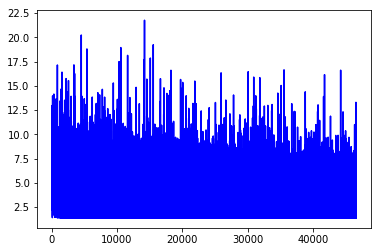

In [90]:
t0 = time.time()
error_losses = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        print("Epoch " + str(epoch) + " / " + str(epochs))
        np.random.shuffle(sentences)
        
        for sentence in sentences:
            sentence = [w for w in sentence \
                if np.random.random() < (1 - p_drop[w])
            ]
            if len(sentence) < 2:
                continue
            
            # randomly order words so we don't always see
            # samples in the same order
            randomly_ordered_positions = np.random.choice(
                len(sentence),
                size=len(sentence),
                replace=False,
            )
            
            for pos in randomly_ordered_positions:
                # the middle word
                word = sentence[pos]

                # get the positive context words/negative samples
                context_words = get_context(pos, sentence, window_size)
                neg_word = np.random.choice(vocab_size, p=p_neg)
                targets = np.array(context_words)                
                _, error_loss = sess.run([train, loss], feed_dict={
                    pos_input: [word],
                    neg_input: [neg_word],
                    context_input: context_words
                })
                
            error_losses.append(error_loss)
            
            if len(error_losses) % 100 == 0:
                print("Error loss at " + str(len(error_losses)) + "/" + str(len(sentences)) + ": " + str(error_loss))
        
        learning_rate -= learning_rate_delta
t1 = time.time()
print("Training time: " + str(t1-t0))
plt.plot(error_losses, color='blue')      

In [91]:
def test_model(word2idx, W, V):
  # there are multiple ways to get the "final" word embedding
  # We = (W + V.T) / 2
  # We = W

  idx2word = {i:w for w, i in word2idx.items()}

  for We in (W, (W + V.T) / 2):
    print("**********")

    analogy('king', 'man', 'queen', 'woman', word2idx, idx2word, We)
    analogy('king', 'prince', 'queen', 'princess', word2idx, idx2word, We)
    analogy('miami', 'florida', 'dallas', 'texas', word2idx, idx2word, We)
    analogy('einstein', 'scientist', 'picasso', 'painter', word2idx, idx2word, We)
    analogy('japan', 'sushi', 'england', 'bread', word2idx, idx2word, We)
    analogy('man', 'woman', 'he', 'she', word2idx, idx2word, We)
    analogy('man', 'woman', 'uncle', 'aunt', word2idx, idx2word, We)
    analogy('man', 'woman', 'brother', 'sister', word2idx, idx2word, We)
    analogy('man', 'woman', 'husband', 'wife', word2idx, idx2word, We)
    analogy('man', 'woman', 'actor', 'actress', word2idx, idx2word, We)
    analogy('man', 'woman', 'father', 'mother', word2idx, idx2word, We)
    analogy('heir', 'heiress', 'prince', 'princess', word2idx, idx2word, We)
    analogy('nephew', 'niece', 'uncle', 'aunt', word2idx, idx2word, We)
    analogy('france', 'paris', 'japan', 'tokyo', word2idx, idx2word, We)
    analogy('france', 'paris', 'china', 'beijing', word2idx, idx2word, We)
    analogy('february', 'january', 'december', 'november', word2idx, idx2word, We)
    analogy('france', 'paris', 'germany', 'berlin', word2idx, idx2word, We)
    analogy('week', 'day', 'year', 'month', word2idx, idx2word, We)
    analogy('week', 'day', 'hour', 'minute', word2idx, idx2word, We)
    analogy('france', 'paris', 'italy', 'rome', word2idx, idx2word, We)
    analogy('paris', 'france', 'rome', 'italy', word2idx, idx2word, We)
    analogy('france', 'french', 'england', 'english', word2idx, idx2word, We)
    analogy('japan', 'japanese', 'china', 'chinese', word2idx, idx2word, We)
    analogy('china', 'chinese', 'america', 'american', word2idx, idx2word, We)
    analogy('japan', 'japanese', 'italy', 'italian', word2idx, idx2word, We)
    analogy('japan', 'japanese', 'australia', 'australian', word2idx, idx2word, We)
    analogy('walk', 'walking', 'swim', 'swimming', word2idx, idx2word, We)

In [92]:
test_model(word2idx, W, V)

**********
testing: king - man = queen - woman
got: king - man = osman - woman
closest 10:
king 0.38868016
osman 0.44295055
prohibits 0.48708928
probes 0.5090289
classically 0.51096714
upon 0.52897453
reconstruct 0.530018
deck 0.5306651
distribution 0.53235215
crash 0.5348824
dist to queen: 0.9202968776226044
testing: king - prince = queen - princess
got: king - prince = pas - princess
closest 10:
princess 0.33188254
pas 0.47077936
106 0.48913044
punctuation 0.497392
king 0.50102305
intestine 0.5146658
pun 0.5190325
tentative 0.5227813
consecrated 0.5273456
singles 0.53417
dist to queen: 1.0953312665224075
testing: miami - florida = dallas - texas
got: miami - florida = 10 - texas
closest 10:
texas 0.3318866
10 0.50429916
presses 0.5072386
processor 0.5087693
layout 0.52151525
descartes 0.522684
plundered 0.5241772
neighbor 0.52692866
satyrs 0.5358587
massacred 0.53844094
dist to dallas: 1.3311095535755157
testing: einstein - scientist = picasso - painter
got: einstein - scientist = ra

got: man - woman = transistor - sister
closest 10:
sister 0.36315298
transistor 0.46413928
jaguar 0.48483986
papal 0.5058025
hillary 0.5339289
debate 0.53520775
15thcentury 0.5487013
man 0.5550897
fitted 0.55662274
microsofts 0.55827916
dist to brother: 0.6905505955219269
testing: man - woman = husband - wife
got: man - woman = architect - wife
closest 10:
architect 0.5088313
ratified 0.5100119
methodist 0.5148456
wikipedia 0.51876664
man 0.5218667
societys 0.52311933
wife 0.53503656
transistor 0.5371397
quartet 0.5411476
alienation 0.5487287
dist to husband: 0.7773336619138718
testing: man - woman = actor - actress
got: man - woman = corridor - actress
closest 10:
actress 0.4545914
corridor 0.47262174
liable 0.5056697
dream 0.5106241
dots 0.53565645
legendary 0.53685045
blackjack 0.5388324
3rdcentury 0.5439559
liquid 0.5516341
absorbing 0.555812
dist to actor: 0.9354490414261818
testing: man - woman = father - mother
got: man - woman = rigid - mother
closest 10:
mother 0.40415478
rigi